In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
DDoS=pd.read_csv('/content/dataset_sdn.csv')

In [4]:
DDoS.Protocol.unique()
DDoS['Protocol'] = DDoS['Protocol'].replace('TCP', '0')
DDoS['Protocol'] = DDoS['Protocol'].replace('UDP', '1')
DDoS['Protocol'] = DDoS['Protocol'].replace('ICMP', '2')
DDoS.Protocol.unique()

array(['1', '0', '2'], dtype=object)

In [14]:
DDoS['src'] = DDoS['src'].replace('10.0.0.0', '0')
DDoS['src'] = DDoS['src'].replace('10.0.0.2', '1')
DDoS['src'] = DDoS['src'].replace('10.0.0.4', '2')
DDoS['src'] = DDoS['src'].replace('10.0.0.10', '3')
DDoS['src'] = DDoS['src'].replace('10.0.0.5', '4')
DDoS['src'] = DDoS['src'].replace('10.0.0.13', '5')
DDoS['src'] = DDoS['src'].replace('10.0.0.6', '6')
DDoS['src'] = DDoS['src'].replace('10.0.0.11', '7')
DDoS['src'] = DDoS['src'].replace('10.0.0.20', '8')
DDoS['src'] = DDoS['src'].replace('10.0.0.18', '9')
DDoS['src'] = DDoS['src'].replace('10.0.0.12', '10')
DDoS['src'] = DDoS['src'].replace('10.0.0.1', '11')
DDoS['src'] = DDoS['src'].replace('10.0.0.3', '12')
DDoS['src'] = DDoS['src'].replace('10.0.0.8', '13')
DDoS['src'] = DDoS['src'].replace('10.0.0.7', '14')
DDoS['src'] = DDoS['src'].replace('10.0.0.9', '15')
DDoS['src'] = DDoS['src'].replace('10.0.0.14', '16')
DDoS['src'] = DDoS['src'].replace('10.0.0.15', '17')
DDoS['src'] = DDoS['src'].replace('10.0.0.16', '18')
DDoS['src'] = DDoS['src'].replace('10.0.0.17', '19')
DDoS.src.unique()

array(['11', '1', '2', '3', '12', '4', '5', '6', '8', '7', '10', '9',
       '13', '14', '15', '16', '17', '18', '19'], dtype=object)

In [16]:
DDoS['dst'] = DDoS['dst'].replace('10.0.0.8', '0')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.7', '1')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.2', '2')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.4', '3')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.6', '4')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.10', '5')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.3', '6')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.6', '7')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.5', '8')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.9', '9')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.12', '10')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.13', '11')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.14', '12')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.11', '13')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.16', '14')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.1', '15')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.15', '16')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.17', '17')
DDoS['dst'] = DDoS['dst'].replace('10.0.0.18', '18')
DDoS.dst.unique()

array(['0', '1', '6', '8', '5', '11', '15', '13', '2', '3', '9', '4',
       '12', '16', '10', '14', '17', '18'], dtype=object)

In [17]:
DDoS["rx_kbps"] = DDoS["rx_kbps"].fillna(DDoS["rx_kbps"].mean())

In [18]:
DDoS["tot_kbps"] = DDoS["tot_kbps"].fillna(DDoS["tot_kbps"].mean())

In [19]:
from sklearn.model_selection import train_test_split
X = DDoS[['src','dst','dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow','Protocol' ,'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps']]
y = DDoS['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [20]:
# Feature scaling (or standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# reshape inputs for LSTM [samples, timesteps, features]


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (62607, 1, 22)
Test data shape: (41738, 1, 22)


In [22]:
def create_baseline():
    model = Sequential()
    
    model.add(LSTM(22, activation='tanh', kernel_regularizer='l2'))
    model.add(Dense(64, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [23]:
model = create_baseline()

In [24]:
history = model.fit(X_train, y_train, epochs = 50,validation_split=0.2,verbose = 1)

Epoch 1/50
1566/1566 [==============================] - 11s 4ms/step - loss: 0.5046 - accuracy: 0.8793 - val_loss: 0.4058 - val_accuracy: 0.9294
Epoch 2/50
1566/1566 [==============================] - 9s 6ms/step - loss: 0.3856 - accuracy: 0.9385 - val_loss: 0.3772 - val_accuracy: 0.9419
Epoch 3/50
1566/1566 [==============================] - 7s 5ms/step - loss: 0.3679 - accuracy: 0.9439 - val_loss: 0.3655 - val_accuracy: 0.9441
Epoch 4/50
1566/1566 [==============================] - 8s 5ms/step - loss: 0.3591 - accuracy: 0.9441 - val_loss: 0.3584 - val_accuracy: 0.9457
Epoch 5/50
1566/1566 [==============================] - 10s 7ms/step - loss: 0.3536 - accuracy: 0.9453 - val_loss: 0.3533 - val_accuracy: 0.9457
Epoch 6/50
1566/1566 [==============================] - 7s 5ms/step - loss: 0.3498 - accuracy: 0.9456 - val_loss: 0.3523 - val_accuracy: 0.9406
Epoch 7/50
1566/1566 [==============================] - 8s 5ms/step - loss: 0.3476 - accuracy: 0.9463 - val_loss: 0.3495 - val_accurac

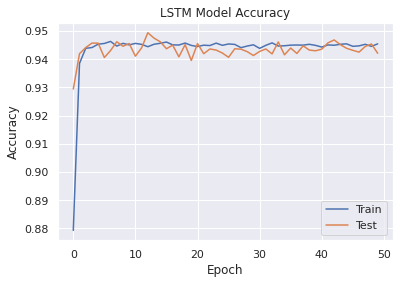

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('LSTM Model Accuracy.png')
plt.show()

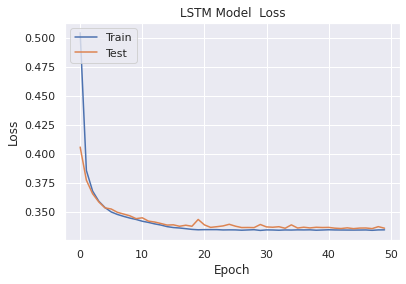

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('LSTM Model Loss.png')
plt.show()

In [27]:
predict = model.predict(X_test, verbose=1)

1305/1305 [==============================] - 3s 2ms/step


In [28]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1

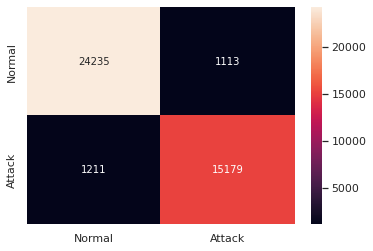

In [29]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Normal","Attack"],columns = ["Normal","Attack"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [30]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 94.43%
